<font size="+3">Inference Notebook</font>

Explore simple ML models, different text embeddings, hyper parameter tuning and ensemble models.

The BERT model got an accuracy of about 0.83 without any feature engineering. It will be interesting to see if traditional ML models can be tuned to perform as well/better than BERT.

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, log_loss

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import xgboost as xgb

# Load Data

In [2]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [3]:
features = [col for col in train_df.columns if col not in ['target','id']]

In [4]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train_df[features], train_df['target'], test_size=0.1,
                                                 shuffle=True, random_state = 42)

xtest = test_df

In [5]:
xtrain.sample(10)

,keyword,location,text
7389,windstorm,Argus Industries \m/666\m/,Damn...was wondering where my drone ended up a...
6804,tragedy,MÌ©xico,I'm gunning down romance\nIt never did a thing...
6478,sunk,{GoT | Modern AU | Lizz},@UntamedDirewolf 'I... Wow. Alright.' Sansa sh...
4641,inundated,The windy plains of Denver,@VZWSupport do texts use data? She was inundat...
7247,weapons,NaN,@kirstiealley @_AnimalAdvocate Or pay it for a...
1018,body%20bags,"Austin, Texas",@FoxNews @JenGriffinFNC When you call to repor...
3268,engulfed,NaN,Men escape car engulfed in flames in Parley's ...
6501,survive,NaN,@lucypalladino and I don't have any classes to...
282,apocalypse,Oakland,Julie + R is the apocalypse version of Romeo +...
3333,evacuated,"Denver, Colorado",13000 evacuated as California firefighters fig...


# Metric

As per the competition rules. We will optimise for the F1_Score and also use the log_loss to evaluate each algorithms performance.

# Text Preprocessing

As we will evalute different levels of text preprocessing, the processing steps will be kept in a seperate file so they can easily be added to as we evaluate each model. This will enable us to add different level of preprocessing to the pipelines.

See `TweetProcessor` in `text_preprocessing.py` for text cleaning steps.

In [6]:
%load_ext autoreload
%autoreload 2

from text_preprocessing import TweetProcessor

In [7]:
tp = TweetProcessor()
xtrain['text'] = tp.process_text(xtrain['text'])
xvalid['text'] = tp.process_text(xvalid['text'])
xtest['text'] = tp.process_text(xtest['text'])

# Simple ML Models

To begin with we will just evaluate the `text` column and create features from that.

## Bag of words

There are a number of different methods for generating numerical features from text. We can try the following:
- TF-IDF
- CountVectorizer

We will create features from using each method and evaluate which works better on this dataset.

In [8]:
# TF-IDF embeddings
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Count Vectorizer
ctv = CountVectorizer(stop_words = 'english')

## Logistic Regression

The first model to try is a simple logistic regression. We will use sklearn pipelines and gridsearch to find the best possible logistic regression model.

In [9]:
#create dictionary to store results of each model
model_results = {}

In [10]:
#standard logistic regresssion
lr_pipe_tfv = Pipeline([('tfv',tfv),
                        ('lr',LogisticRegression())])

lr_pipe_ctv = Pipeline([('ctv',ctv),
                        ('lr',LogisticRegression())])

#gridsearch parameters
lr_param_grid = {'lr__C': [0.1, 1.0, 10],
                'lr__penalty': ['l1', 'l2']}

In [11]:
#pipelines with svd and scaling
lr_pipe_tfv_svd = Pipeline([('tfv',tfv),
                        ('svd',TruncatedSVD()),
                        ('scl',StandardScaler()),
                        ('lr',LogisticRegression())])

lr_pipe_ctv_svd = Pipeline([('ctv',ctv),
                        ('svd',TruncatedSVD()),
                        ('scl',StandardScaler()),
                        ('lr',LogisticRegression())])

lr_svd_param_grid = {'svd__n_components' : [120, 180],
                 'lr__C': [0.1, 1.0, 10], 
                 'lr__penalty': ['l1', 'l2']}

In [12]:
lr_gs_tfv = GridSearchCV(lr_pipe_tfv, param_grid=lr_param_grid, scoring='f1',
                     verbose=5, n_jobs=-1, refit=True, cv=4)

lr_gs_ctv = GridSearchCV(lr_pipe_ctv, param_grid=lr_param_grid, scoring='f1',
                     verbose=5, n_jobs=-1, refit=True, cv=4)

lr_svd_gs_tfv = GridSearchCV(lr_pipe_tfv_svd, param_grid=lr_svd_param_grid, scoring='f1',
                     verbose=5, n_jobs=-1, refit=True, cv=4)

lr_svd_gs_ctv = GridSearchCV(lr_pipe_ctv_svd, param_grid=lr_svd_param_grid, scoring='f1',
                     verbose=5, n_jobs=-1, refit=True, cv=4)


In [13]:
models = [lr_gs_tfv, lr_gs_ctv, lr_svd_gs_tfv, lr_svd_gs_ctv]
names = ['lr-tfv','lr-ctv','lr-svd-tfv','lr-svd-ctv']

for model, name in zip(models,names):
    print(f"\nTraining model: {name}")
    model.fit(xtrain['text'],ytrain)
    
print("\nHyper-parameter tuning done")


Training model: lr-tfv
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    7.8s finished



Training model: lr-ctv
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    3.2s finished



Training model: lr-svd-tfv
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   29.4s finished



Training model: lr-svd-ctv
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   39.1s finished



Hyper-parameter tuning done


In [14]:
def evaluate_gridsearch_models(models,names,xvalid):
    val_scores = {}
    for model, name in zip(models, names):
        print(f"{name}: \n\tBest GridSearch score: {model.best_score_: 0.4f}")
        predictions = model.predict(xvalid)
        val_score = f1_score(yvalid,predictions)
        print(f"\tScore on validation set: {val_score: 0.4f}")
        val_scores[name] = val_score
            
    return val_scores
    

lr_val_scores = evaluate_gridsearch_models(models,names,xvalid['text'])

lr-tfv: 
	Best GridSearch score:  0.7433
	Score on validation set:  0.7227
lr-ctv: 
	Best GridSearch score:  0.7450
	Score on validation set:  0.7212
lr-svd-tfv: 
	Best GridSearch score:  0.7261
	Score on validation set:  0.6974
lr-svd-ctv: 
	Best GridSearch score:  0.7025
	Score on validation set:  0.6902


Looks like the model with best performance on the unseen validation set is the best Logistic Regression model with CountVectorizer features.

In [15]:
#record best model into dictionary for comparison with other models later
model_results['lr-ctv'] = {'model': lr_gs_ctv, 'score': lr_val_scores['lr-ctv']}

**Classification report for best logistic regression model**

Log loss: 0.499 
F1 score: 0.721 
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       426
           1       0.78      0.67      0.72       336

    accuracy                           0.77       762
   macro avg       0.77      0.76      0.76       762
weighted avg       0.77      0.77      0.77       762



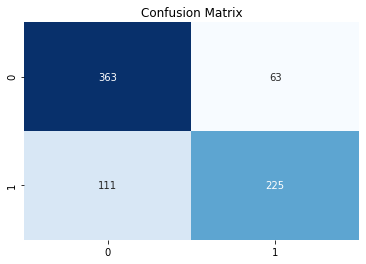

In [16]:
def create_classification_report(model):
    """Print classification report and confusion matrix"""
    predictions_prob = model.predict_proba(xvalid['text'])
    predictions_classes = model.predict(xvalid['text'])

    print ("Log loss: %0.3f " % log_loss(yvalid, predictions_prob))
    print("F1 score: %0.3f " % f1_score(yvalid, predictions_classes))
    print(classification_report(yvalid, predictions_classes))

    sns.heatmap(confusion_matrix(yvalid,predictions_classes),annot=True,fmt='.0f',cmap='Blues', cbar=False)
    plt.title("Confusion Matrix")
    plt.show()
    
create_classification_report(lr_gs_ctv)

## Naive Bayes

In [17]:
nb = MultinomialNB()

In [18]:
nb_pipeline_tfv = Pipeline([('tfv',tfv),
                      ('nb',nb)])

nb_pipeline_ctv = Pipeline([('ctv',ctv),
                      ('nb',nb)])

In [19]:
nb_param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}


In [20]:
nb_gs_tfv = GridSearchCV(nb_pipeline_tfv, param_grid=nb_param_grid, scoring='f1',
                     verbose=5, n_jobs=-1, refit=True, cv=4)

nb_gs_ctv = GridSearchCV(nb_pipeline_ctv, param_grid=nb_param_grid, scoring='f1',
                     verbose=5, n_jobs=-1, refit=True, cv=4)

In [21]:
models = [nb_gs_tfv, nb_gs_ctv]
names = ['nb-tfv','nb-ctv']

for model, name in zip(models,names):
    print(f"\nTraining model: {name}")
    model.fit(xtrain['text'],ytrain)

print("Hyper-parameter tuning done")


Training model: nb-tfv
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    6.5s finished



Training model: nb-ctv
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s


Hyper-parameter tuning done


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.5s finished


In [22]:
nb_val_scores = evaluate_gridsearch_models(models,names,xvalid['text'])

nb-tfv: 
	Best GridSearch score:  0.7322
	Score on validation set:  0.7092
nb-ctv: 
	Best GridSearch score:  0.7512
	Score on validation set:  0.7339


Log loss: 0.763 
F1 score: 0.734 
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       426
           1       0.78      0.69      0.73       336

    accuracy                           0.78       762
   macro avg       0.78      0.77      0.77       762
weighted avg       0.78      0.78      0.78       762



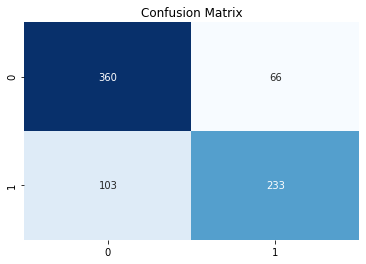

In [23]:
create_classification_report(nb_gs_ctv)

In [24]:
#record best model into dictionary for comparison with other models later
model_results['nb-ctv'] = {'model': nb_gs_ctv, 'score': nb_val_scores['nb-ctv']}

# Glove Embeddings

Glove vectors is another method for generating features from text.

Note that the text file containing the embeddings can be downloaded from `http://www-nlp.stanford.edu/data/glove.840B.300d.zip` - it is not included in this git repository due to its large size.

In [ ]:
from tqdm import tqdm

EMBEDDINGS_LOCATION = '../external/glove.840B.300d/glove.840B.300d/glove.840B.300d.txt'


# load the GloVe vectors in a dictionary:
embeddings_index = {}    
f = open(EMBEDDINGS_LOCATION, "r", encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

1110707it [02:05, 8932.61it/s]

## XGBoost

Finally, we will try an XGBoost model

In [ ]:
xgb_clf = xgb.XGBClassifier(max_df=0.95)

In [ ]:
xgb_pipe_tfv = Pipeline([('tfv',tfv),
                         ('xgb',xgb_clf)
    
])


xgb_pipe_ctv = Pipeline([('ctv',ctv),
                         ('xgb',xgb_clf)
    
])

In [ ]:
xgb_param_grid = {"xgb__n_estimators": np.arange(400, 10000, 1000), 'xgb__max_depth': range(1, 20,10)}

In [ ]:
xgb_gs_tfv = GridSearchCV(xgb_pipe_tfv, param_grid=xgb_param_grid, scoring='f1',
                     verbose=10, n_jobs=-1, refit=True, cv=4)

xgb_gs_ctv = GridSearchCV(xgb_pipe_ctv, param_grid=xgb_param_grid, scoring='f1',
                     verbose=10, n_jobs=-1, refit=True, cv=4)

In [ ]:
xgb_gs_tfv.fit(xtrain['text'],ytrain)
xgb_gs_ctv.fit(xtrain['text'],ytrain)

print("Hyperparameter tuning complete")

In [ ]:
create_classification_report(xgb_gs_tfv)

# Make Submission

In [29]:
def create_submission_csv(model,model_name,processed_test_data):
    """Make preidctions on test set and save to dataframe
    
    Args:
        model: grid search model
        model_name (str): name of model to include in the file name of saved model
        processed_test_data(df): preprocessed test data

    """
    preds = model.predict(processed_test_data)
    final_predictions_df = pd.DataFrame({'id':test_df['id'],'target':preds})
    final_predictions_df.to_csv(f"./submissions/{model_name}.csv",index=False)

In [30]:
create_submission_csv(clf,'stacking',xtest['text'])

# Resources

Many ideas for this notebook can from this [notebook](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) from Kaggle Grandmaster Abhishek Thakur. I would recommend checking out more of his [content](https://www.youtube.com/user/abhisheksvnit), he has great tutorials particularly on using BERT with PyTorch.